In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from modules import Base, Streets, GreenAreas, Amenities, LandUses

In [2]:
import zipfile
import os

def verificar_y_crear_directorio(directory_path):
    # Verificar si el directorio ya existe
    if not os.path.exists(directory_path):
        try:
            # Crear el directorio si no existe
            os.makedirs(directory_path)
            print(f"Directorio '{directory_path}' creado con éxito.")
        except OSError as e:
            print(f"Error al crear el directorio '{directory_path}': {str(e)}")
    else:
        print(f"El directorio '{directory_path}' ya existe.")

def zip_folder(input_folder_path, output_zip_path):
    try:
        # Crear un objeto ZipFile en modo escritura
        with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Recorre todos los archivos y subdirectorios en la carpeta de entrada
            for root, _, files in os.walk(input_folder_path):
                for file in files:
                    # Obtiene la ruta completa del archivo
                    file_path = os.path.join(root, file)
                    
                    # Calcula la ruta relativa dentro del archivo .zip
                    relative_path = os.path.relpath(file_path, input_folder_path)
                    
                    # Agrega el archivo al archivo .zip con la ruta relativa
                    zipf.write(file_path, arcname=relative_path)

        print(f"Carpeta '{input_folder_path}' comprimida en '{output_zip_path}' con éxito.")
    except Exception as e:
        print(f"Error al comprimir la carpeta: {str(e)}")

def calcular_tiempo(distancia_metros):
    velocidad_kph = 4.5
    velocidad_mpm = velocidad_kph * 1000 / 60
    tiempo = (distancia_metros / velocidad_mpm)
    return tiempo

In [20]:
class TableUserInferface():
    ######################################################################
    #### Funciones generales del modulo
    ######################################################################

    def __init__(self) -> None:
        self.st = Streets.Streets()
        self.ga = GreenAreas.GreenAreas()
        self.am = Amenities.Amenities()
        self.lu = LandUses.LandUses()
        self.load_unit()
        self.modules_available = [
            'GreenAreas',
            'Streets',
            'Amenities',
            'LandUses',
        ]
        self.dict_scenarios = {
            0: 'actual',
            1: 'future',
        }
        self.present_scenario = 0
        self.update_nodes_ids()
        pass

    def change_scenario(self, scenario_id):
        if self.present_scenario!=scenario_id:
            self.st.go_to_scenario(scenario_id)
            self.ga.go_to_scenario(scenario_id)
            self.am.go_to_scenario(scenario_id)
            self.lu.go_to_scenario(scenario_id)
            self.update_nodes_ids()
            self.present_scenario=scenario_id
        pass

    def update_nodes_ids(self):
        self.calc_ga_node_ids()
        self.calc_am_node_ids()
        self.calc_unit_node_ids()
    
    def calc_kpis(self):
        if 'Amenities' in self.modules_available: self.calc_travel_time_to_amenities()
        if 'GreenAreas' in self.modules_available: self.calc_travel_time_to_green_areas()
        if 'LandUses' in self.modules_available: self.calc_land_uses_diversity()
        pass

    ######################################################################    
    #### Funciones de unidades espaciales
    ######################################################################

    def load_unit(self, select_unit='hex'):
        self.select_unit=select_unit
        unit = gpd.read_file(f'/app/assets/groupby/{self.select_unit}')
        unit['centroid'] = unit['geometry'].centroid
        self.unit = unit
        pass

    def calc_unit_node_ids(self):
        self.unit['node_ids'] = self.st.current_scenario['net'].get_node_ids(
            self.unit['centroid'].x,
            self.unit['centroid'].y
        )
        pass
    

    ######################################################################
    #### Funciones para identificar nodos en lugares
    ######################################################################

    def calc_am_node_ids(self):
        self.am.node_set = self.am.current_scenario.copy()
        self.am.node_set['node_ids'] = self.st.current_scenario['net'].get_node_ids(
            self.am.node_set['geometry'].x,
            self.am.node_set['geometry'].y
        )
        pass

    def calc_ga_node_ids(self):
        nodes_df, _ = self.st.get_current_nodes_and_edges()
        net = self.st.current_scenario['net']
        ga_idxs = self.ga.get_green_areas_ids()
        ga_nodes_set = []
        for idx in ga_idxs:
            points = pd.DataFrame(self.ga.get_countour_by_id(idx), columns=['x', 'y', 'key'])
            ga_nodes_ids = net.get_node_ids(points['x'], points['y'])
            ga_nodes = nodes_df[nodes_df['osmid'].isin(ga_nodes_ids)]
            ga_nodes['ID_AV'] = idx
            ga_nodes_set.append(ga_nodes)

        ga_nodes_set = pd.concat(ga_nodes_set)
        ga_nodes_set.drop_duplicates('osmid', inplace=True)
        ga_nodes_set.reset_index(inplace=True, drop=True)
        self.ga.node_set = ga_nodes_set
        pass

    ######################################################################
    #### Funciones para calculo de diversidad
    ######################################################################

    def calc_land_uses_diversity(self):
        self.unit['area_unit'] = self.unit.area
        # Intersection between land_uses and units
        intersection = gpd.sjoin(self.unit, self.lu.get_current_land_uses(), how="inner", op="intersects")
        intersection['area'] = intersection.area

        # Filter intersection geodataframe by columns
        inter_cols = [f'{self.select_unit}_id', 'Uso', 'area', 'area_unit', 'area_predio']
        intersection = intersection[inter_cols]

        total_inter_area = intersection.groupby([f'{self.select_unit}_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
        intersection = pd.merge(intersection, total_inter_area, on=f'{self.select_unit}_id')
        intersection['property_percentage'] = intersection['area']/intersection['inter_area']
        intersection['information_per_property'] = -1*intersection['property_percentage']*np.log(intersection['property_percentage'])
        diversity = intersection.groupby(f'{self.select_unit}_id')['information_per_property'].agg('sum').reset_index()
        diversity_map = pd.merge(diversity, self.unit, on=f'{self.select_unit}_id')
        diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)
        self.lu_diversity = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])
        self.unit.drop(columns=['area_unit'], inplace=True)
        pass

    ######################################################################
    #### Funciones para calculo de proximidades
    ######################################################################

    def calc_travel_time_to_amenities(self):
        results_df = []
        # Calcular el camino más corto desde cada centroide de teselado hasta todos los nodos de amenities
        for index, row in self.am.get_current_amenities().iterrows():
            # print(row['geometry'])
            # print(row)
            destination_node_id = self.st.current_scenario['net'].get_node_ids([row['geometry'].x], [row['geometry'].y])
            destination_node_id = list(destination_node_id)[0]

            sources = self.unit['node_ids']
            destinations = [destination_node_id]*len(self.unit['node_ids'])

            shortest_paths = self.st.current_scenario['net'].shortest_path_lengths(sources, destinations)
            results_df.append(
                pd.DataFrame.from_dict(
                    {
                        'source': sources,
                        'destination': destinations,
                        f'{self.select_unit}_id': self.unit[f'{self.select_unit}_id'],
                        'Category': [row['Category']]*len(self.unit['node_ids']),
                        'path_lengths': shortest_paths,
                    }
                )
            )
        
        results_df = pd.concat(results_df)
        # display(results_df)

        # Encuentra el valor mínimo para cada categoría de amenity
        unit_cat = [f'{self.select_unit}_id','Category']
        paths_output = results_df.groupby(unit_cat)['path_lengths'].min().reset_index()
        paths_output = pd.merge(paths_output, results_df, on=unit_cat+['path_lengths'])
        paths_output = pd.merge(paths_output, self.unit[[f'{self.select_unit}_id','geometry']], on=f'{self.select_unit}_id')
        # display(paths_output)

        columns = ['source', 'destination', 'path_lengths', 'Category', f'{self.select_unit}_id', 'geometry']
        self.gdf_am_paths = gpd.GeoDataFrame(data=paths_output.drop(columns=['geometry']), geometry=paths_output['geometry'])
        self.gdf_am_paths = self.gdf_am_paths[columns]

        self.gdf_am_paths['travel_time'] = self.gdf_am_paths['path_lengths'].apply(calcular_tiempo)
        pass

        
    def calc_travel_time_to_green_areas(self):
        paths_output = []

        for idx in range(len(self.unit)):
            source = self.unit.loc[idx, 'node_ids']
            source = [source]*len(self.ga.node_set)
            destination = self.ga.node_set['osmid']
            paths = self.st.current_scenario['net'].shortest_path_lengths(source, self.ga.node_set['osmid'])
            paths_df = pd.DataFrame.from_dict({
                'source': source,
                'destination': destination,
                'path_lengths': paths
            })
            paths_df.sort_values(by=['path_lengths'], inplace=True)
            # display(paths_df)
            paths_df.reset_index(inplace=True, drop=True)
            paths_df = paths_df.head(1)
            paths_df['ID_AV'] = self.ga.node_set[self.ga.node_set['osmid'] == paths_df.loc[0,'destination']]['ID_AV'].values[0]
            paths_df[f'{self.select_unit}_id'] = self.unit.loc[idx, f'{self.select_unit}_id']
            paths_output.append(paths_df)

        paths_output = pd.concat(paths_output)
        paths_output.reset_index(inplace=True, drop=True)
        paths_output = pd.merge(paths_output, self.unit, on=f'{self.select_unit}_id')

        columns = ['source', 'destination', 'path_lengths', 'ID_AV', f'{self.select_unit}_id', 'geometry']
        self.gdf_ga_paths = gpd.GeoDataFrame(data=paths_output.drop(columns=['geometry']), geometry=paths_output['geometry'])
        self.gdf_ga_paths = self.gdf_ga_paths[columns]

        self.gdf_ga_paths['travel_time'] = self.gdf_ga_paths['path_lengths'].apply(calcular_tiempo)
        pass

    ######################################################################
    #### Funciones GET
    ######################################################################

    def get_streets(self):
        return self.st if 'Streets' in self.modules_available else None
    
    def get_green_area(self):
        return self.ga if 'GreenAreas' in self.modules_available else None
    
    def get_amenities(self):
        return self.am if 'Amenities' in self.modules_available else None
    
    def get_travels_amenities(self):
        return self.gdf_am_paths
    
    def get_travels_green_areas(self):
        return self.gdf_ga_paths
    
    def get_amenities_categories(self):
        return self.am.get_categories()

    def get_travels_amenities_by_category(self, category):
        return self.gdf_am_paths[self.gdf_am_paths['Category']==category].drop(columns=['Category'])

    ######################################################################
    #### Funciones de flujo de datos y archivos
    ######################################################################
    def save_heatmaps(self):
        self.save_amenities_travels()
        self.save_green_areas_travels()
        self.save_land_uses_diversity()
        pass

    def save_land_uses_diversity(self, path='/app/data/land_uses_diversity', zipped=True):
        
        scenario_name = self.dict_scenarios[self.present_scenario]
        scenario_path = f'{path}/{scenario_name}'
        verificar_y_crear_directorio(scenario_path)
        self.lu_diversity.to_file(scenario_path)

        if zipped:
            main = os.path.split(path)[-1]
            output_zip_path = f'/app/data/zip/{main}.zip'
            zip_folder(path, output_zip_path)
            
    def save_amenities_travels(self, path='/app/data/amenities_proximity', zipped=True):
        
        categories = self.get_amenities_categories()
        scenario_name = self.dict_scenarios[self.present_scenario]
        scenario_path = f'{path}/{scenario_name}'
        verificar_y_crear_directorio(scenario_path)
        for category in categories:
            filecat = category.lower().replace(' ','_')
            filename = f'{scenario_path}/{filecat}'
            self.get_travels_amenities_by_category(category).to_file(filename)

        if zipped:
            main = os.path.split(path)[-1]
            output_zip_path = f'/app/data/zip/{main}.zip'
            zip_folder(path, output_zip_path)
            
    def save_green_areas_travels(self, path='/app/data/green_areas_proximity', zipped=True):    
        
        scenario_name = self.dict_scenarios[self.present_scenario]
        scenario_path = f'{path}/{scenario_name}'
        verificar_y_crear_directorio(scenario_path)
        self.get_travels_green_areas().to_file(scenario_path)

        if zipped:
            main = os.path.split(path)[-1]
            output_zip_path = f'/app/data/zip/{main}.zip'
            zip_folder(path, output_zip_path)

In [21]:
tui = TableUserInferface()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [22]:
for scenario in [0, 1]:
    tui.change_scenario(scenario_id=scenario)
    tui.calc_land_uses_diversity()
    tui.save_land_uses_diversity()

Directorio '/app/data/land_uses_diversity/actual' creado con éxito.
Carpeta '/app/data/land_uses_diversity' comprimida en '/app/data/zip/land_uses_diversity.zip' con éxito.
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36894
Setting CH edge vector of size 81442
Range graph removed 81442 edges of 162884
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Directorio '/app/data/land_uses_diversity/future' creado con éxito.
Carpeta '/app/data/land_uses_diversity' comprimida en '/app/data/zip/land_uses_diversity.zip' con éxito.


In [18]:
tui.calc_kpis()

<Axes: >

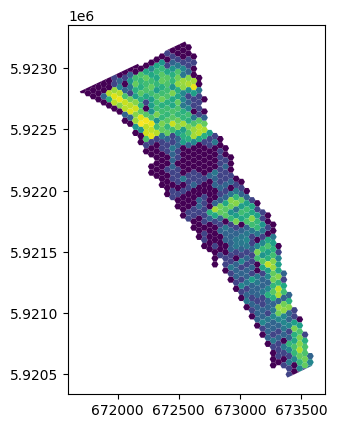

In [19]:
tui.lu_diversity.plot(column='diversity')

<Axes: >

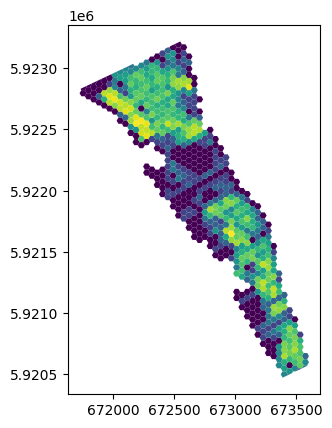

In [16]:
tui.lu_diversity.plot(column='diversity')

In [21]:
gdf = gpd.read_file('/app/data/construcciones_maqueta')

In [26]:
unit = tui.unit

In [40]:
filter_unit = gpd.sjoin(tui.unit, gdf, op='intersects').drop_duplicates(['hex_id'])[['hex_id', 'geometry']] 

Cuidados


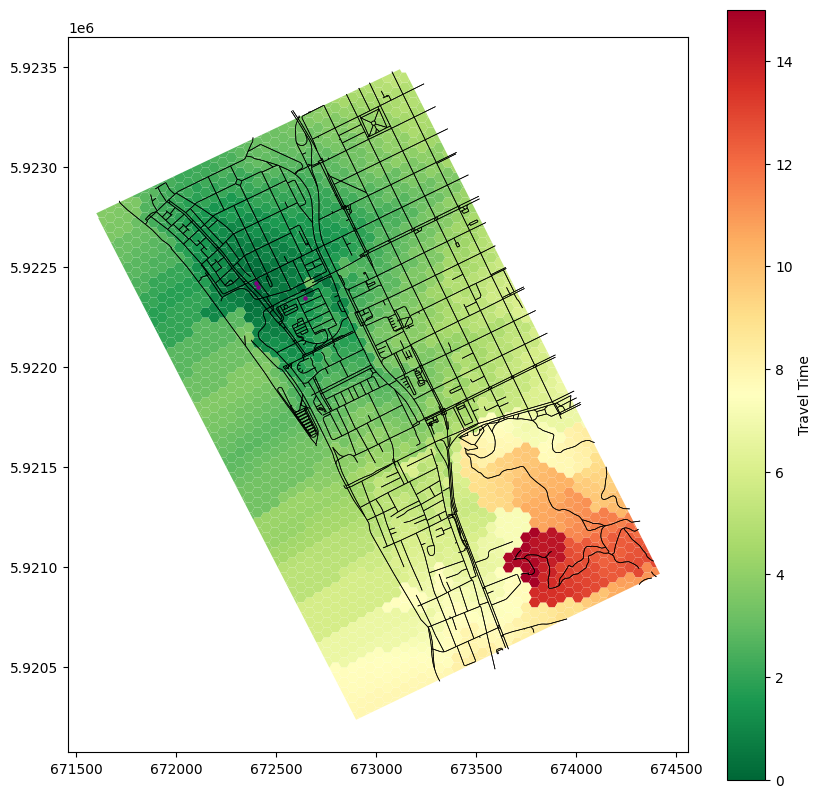

<Axes: >

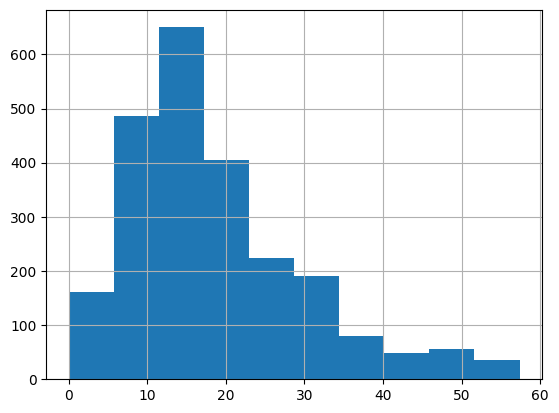

In [43]:
nodes_df, edges_df = tui.st.get_current_nodes_and_edges()
amenities = tui.am.get_current_amenities()

id_category = 6
category = tui.get_amenities_categories()[id_category]
paths = tui.get_travels_amenities_by_category(category)

filtered_map = gpd.sjoin(filter_unit, paths, op='intersects')

# Crear una figura y un eje
fsize = 10
fig, ax = plt.subplots(figsize=(fsize, fsize))

# Crear una paleta de colores personalizada usando RdYlGn
cmap = plt.get_cmap('RdYlGn_r')  # La '_r' indica que la paleta se invierte
# Crear una barra de colores personalizada
# norm = mcolors.Normalize(vmin=min(paths['travel_time']), vmax=max(paths['travel_time']))
norm = mcolors.Normalize(vmin=0, vmax=15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Esto es necesario para que la barra de colores muestre los valores de la paleta

# Crear el gráfico de capas
paths.plot(column='travel_time', cmap=cmap, ax=ax)
# filtered_map.plot(column='travel_time', cmap=cmap, ax=ax)
gpd.sjoin(tui.get_amenities().get_current_amenities_by_category(category), tui.st.area_scope).plot(ax=ax, color='purple', alpha=1, markersize=5)
gpd.sjoin(edges_df, tui.st.area_scope).plot(ax=ax, linewidth=0.5, color='black')
# nodes_df[nodes_df['osmid'].isin(failed_nodes)].plot(ax=ax, markersize=50, color='red')

# Agregar la barra de colores
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Travel Time')

print(category)
# Mostrar el gráfico
plt.show()

paths['travel_time'].hist()

In [20]:
# Para generar todos los mapas

# scenarios_info = tui.dict_scenarios
# for id, name in scenarios_info.items():
#     tui.change_scenario(id)
    
#     tui.calc_kpis()
#     tui.save_heatmaps()